In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import time
%matplotlib notebook 
# For plotting. Don't include this if you submit
                     # a Jupyter Notebook to Gradescope.

In [2]:
def forward_euler(odefun, tspan, y0):
    # Forward Euler method
    # Solves the differential equation y' = f(t,y) at the times
    # specified by the vector tspan and with initial condition y0.
    # - odefun is an anonymous function of the form odefun = lambda t,v: ...
    # - tspan is a 1D array
    # - y0 is a number

    dt = tspan[1] - tspan[0]  # calculate dt from t values
    y = np.zeros(len(tspan))  # Create array of same length as tspan
    y[0] = y0  # Set initial condition
    for k in range(len(y) - 1):
        y[k + 1] = y[k] + dt * odefun(tspan[k], y[k]) # Forward Euler step

    return tspan, y # return two things

def backward_euler(odefun, tspan, y0):
    # Backward Euler method
    # Solves the differential equation y' = f(t,y) at the times
    # specified by the vector tspan and with initial condition y0.
    # - odefun is an anonymous function of the form odefun = lambda t,v: ...
    # - tspan is a 1D array
    # - y0 is a number
    
    dt = tspan[1] - tspan[0]  # calculate dt from t values
    y = np.zeros(len(tspan))  # Create array of same length as tspan
    y[0] = y0  # Set initial condition
    
    for k in range(len(y) - 1):
        g = lambda z: z - y[k] - dt*odefun(tspan[k+1], z) # Implicit equation
        y[k+1] = scipy.optimize.fsolve(g, y[k]) # Defines y[k+1]

    return tspan, y

### Recall, System 2
The next IVP we will solve is
$$ 
\begin{align*}
y(t) &= (5\times 10^5)\times( - y + \sin(t)), ~ 0 \leq t \leq 2\pi \\ 
y(0) &= 0,
\end{align*}
$$
using 100 equally spaced points between $t=0$ and $t=2\pi$. We will compare what the different methods give at $t=2\pi$ using the exact solution at $t=2\pi$ (which I calculated at another time): $y(2\pi) = -1\times10^{-6}$.

In [3]:
# Define the ODE
dydt = lambda t, y: 5e5*(-y+np.sin(t))
# Define the IC
y0 = 0
# Define tspan, the times at which we want the solution
tspan = np.linspace(0, 2*np.pi, 100)
# Define the "exact_sol"
exact_sol = -1e-6

Now solve, time, and find the error for each method.

In [4]:
### Solve using Forward Euler
# Start the timer
time_0 = time.perf_counter()
t, FE_ans = forward_euler(dydt, tspan, y0)
# Stop the timer and print how long it took to solve
time_FE = time.perf_counter() - time_0
print("The time to complete the Forward-Euler solve =", time_FE)
# Calculate the error, using exact_sol
FE_err = np.abs(exact_sol - FE_ans[-1])
print("Forward-Euler error = ", FE_err)
# Run this first to check work, and then use other methods

### Solve using Backward Euler
# Start the timer
time_0 = time.perf_counter()
t, BE_ans = backward_euler(dydt, tspan, y0)
# Stop the timer and print how long it took to solve
time_BE = time.perf_counter() - time_0
print("The time to complete the Backward-Euler solve =", time_BE)
# Calculate the error, using exact_sol
BE_err = np.abs(exact_sol - BE_ans[-1])
print("Backward-Euler error = ", BE_err)

The time to complete the Forward-Euler solve = 0.0009020109999999804
Forward-Euler error =  nan
The time to complete the Backward-Euler solve = 0.010365252000000602
Backward-Euler error =  9.986573507003113e-07


<ipython-input-3-e61549fefad9>:2: RuntimeWarning: overflow encountered in double_scalars
  dydt = lambda t, y: 5e5*(-y+np.sin(t))
<ipython-input-2-58099c0b48bb>:13: RuntimeWarning: invalid value encountered in double_scalars
  y[k + 1] = y[k] + dt * odefun(tspan[k], y[k]) # Forward Euler step


There's a few things to note here.
- First off, `scipy.integrate.solve_ivp` is still going! This may take a while, your computer may get hot. If you need to stop the calculation, go to Kernel -> Interrupt
- Note that we are getting a few warnings here. Some things aren't working as expected. Look at the error for Forward-Euler and midpoint: it says `nan`. This means "Not a Number." This means that the number got too big for python to handle. This means that the method will not work for this problem. 
- Notice that **the only method that's given us an answer so far is Backward-Euler,** and the error is tiny! Even if RK45 does find the solution, we know it's going to be **a lot** slower. So I think we can be pretty confident that *Backward-Euler is the best method to use for this problem,* even if the error for RK45 is a little smaller.

The forward Euler and midpoint methods will not "blow up" if we use enough points in our time interval. We are going to try to incleane the number of points and find the magic number for them to "converge."

The time it takes to solve increases with the number of points we have, because the for loop has to go more times. In the end, it looks like we need about 1e7 = 10 million points in order to get a solution. This obviously takes quite a while, and the error is still not smaller than the Backward-Euler method! 

I think at this point it's pretty clear how we would rank which method we'd use for this problem, at least what the \#1 method is. 

I would definitely choose backward Euler. It is two orders of magnitude faster than RK45 and has the same accuracy as RK45.

BE was the worst choice for solving system 1 (it was the slowest and had the worst error) but it is the best choice for system 2. The reason backward Euler is good in this case is because the explicit methods needed many points (or a very small dt) in order to be *stable*. Differential equations for which is is true are called **stiff problems** or **stiff ODEs**. You generally want *implicit methods* for solving *stiff ODEs*. 

Before explaining more about stability, I want to show you how to solve stiff ODEs using a built-in method. The Backward-Euler method is *implicit* which is what makes it good at solving stiff ODEs, but it's also not very accurate. There are more accurate implicit methods. We will do so using `scipy.integrate.solve_ivp(..., method='BDF')` which means "Backward Differentiation Formula." The syntax is exactly the same as we have used for `solve_ivp` before. It uses a variable-stepsize method as well.

In [5]:
### Solve using scipy.integrate.solve_ivp, using BDF
# Start the timer
time_0 = time.perf_counter()
sol = scipy.integrate.solve_ivp(dydt, 
                            [tspan[0], tspan[-1]],
                            [y0], method='BDF')
# Stop the timer and print how long it took to solve
time_BDF = time.perf_counter() - time_0
print("The time to complete the RK45 solve =", time_BDF)
# Extract the answer from solve_ivp
BDF = sol.y[0]
# Calculate the error, using exact_sol
BDF_err = np.abs(exact_sol - BDF[-1])
print("BDF error = ", BDF_err)

The time to complete the RK45 solve = 0.03452910300000056
BDF error =  1.0001580814357555e-06


Notice that this is extremely fast and has good error! It's actually still worse than Backward Euler in this case, but it could be made more accurate using `rtol`. 

So how do we explain what we are seeing? In order to explain it we need to discuss *stability.*

### Stability
The definition and study of *stability* is a complicated one. Unfortunately, this means that I am also using somewhat non-standard definitions of words like "stable" and "unstable".  If you are interested in the standard definitions, a good place to start is by looking up "A-stability".  

We are not going to go into the details. Very roughly, we will say that a differential equation solver is *unstable* if the numerical solution *blows up* or goess off to infinity as $t\to \infty$. If this does not happen, we call the ODE solver *stable*.  

Let's think about the IVP we were trying to solve above, 
$$ 
\begin{align*}
y(t) &= (5\times 10^5)\times( - y + \sin(t)), ~ 0 \leq t \leq 2\pi \\ 
y(0) &= 0.
\end{align*}
$$
We are going to plot the vector field for this differential equation, using `quiver`.

<IPython.core.display.Javascript object>


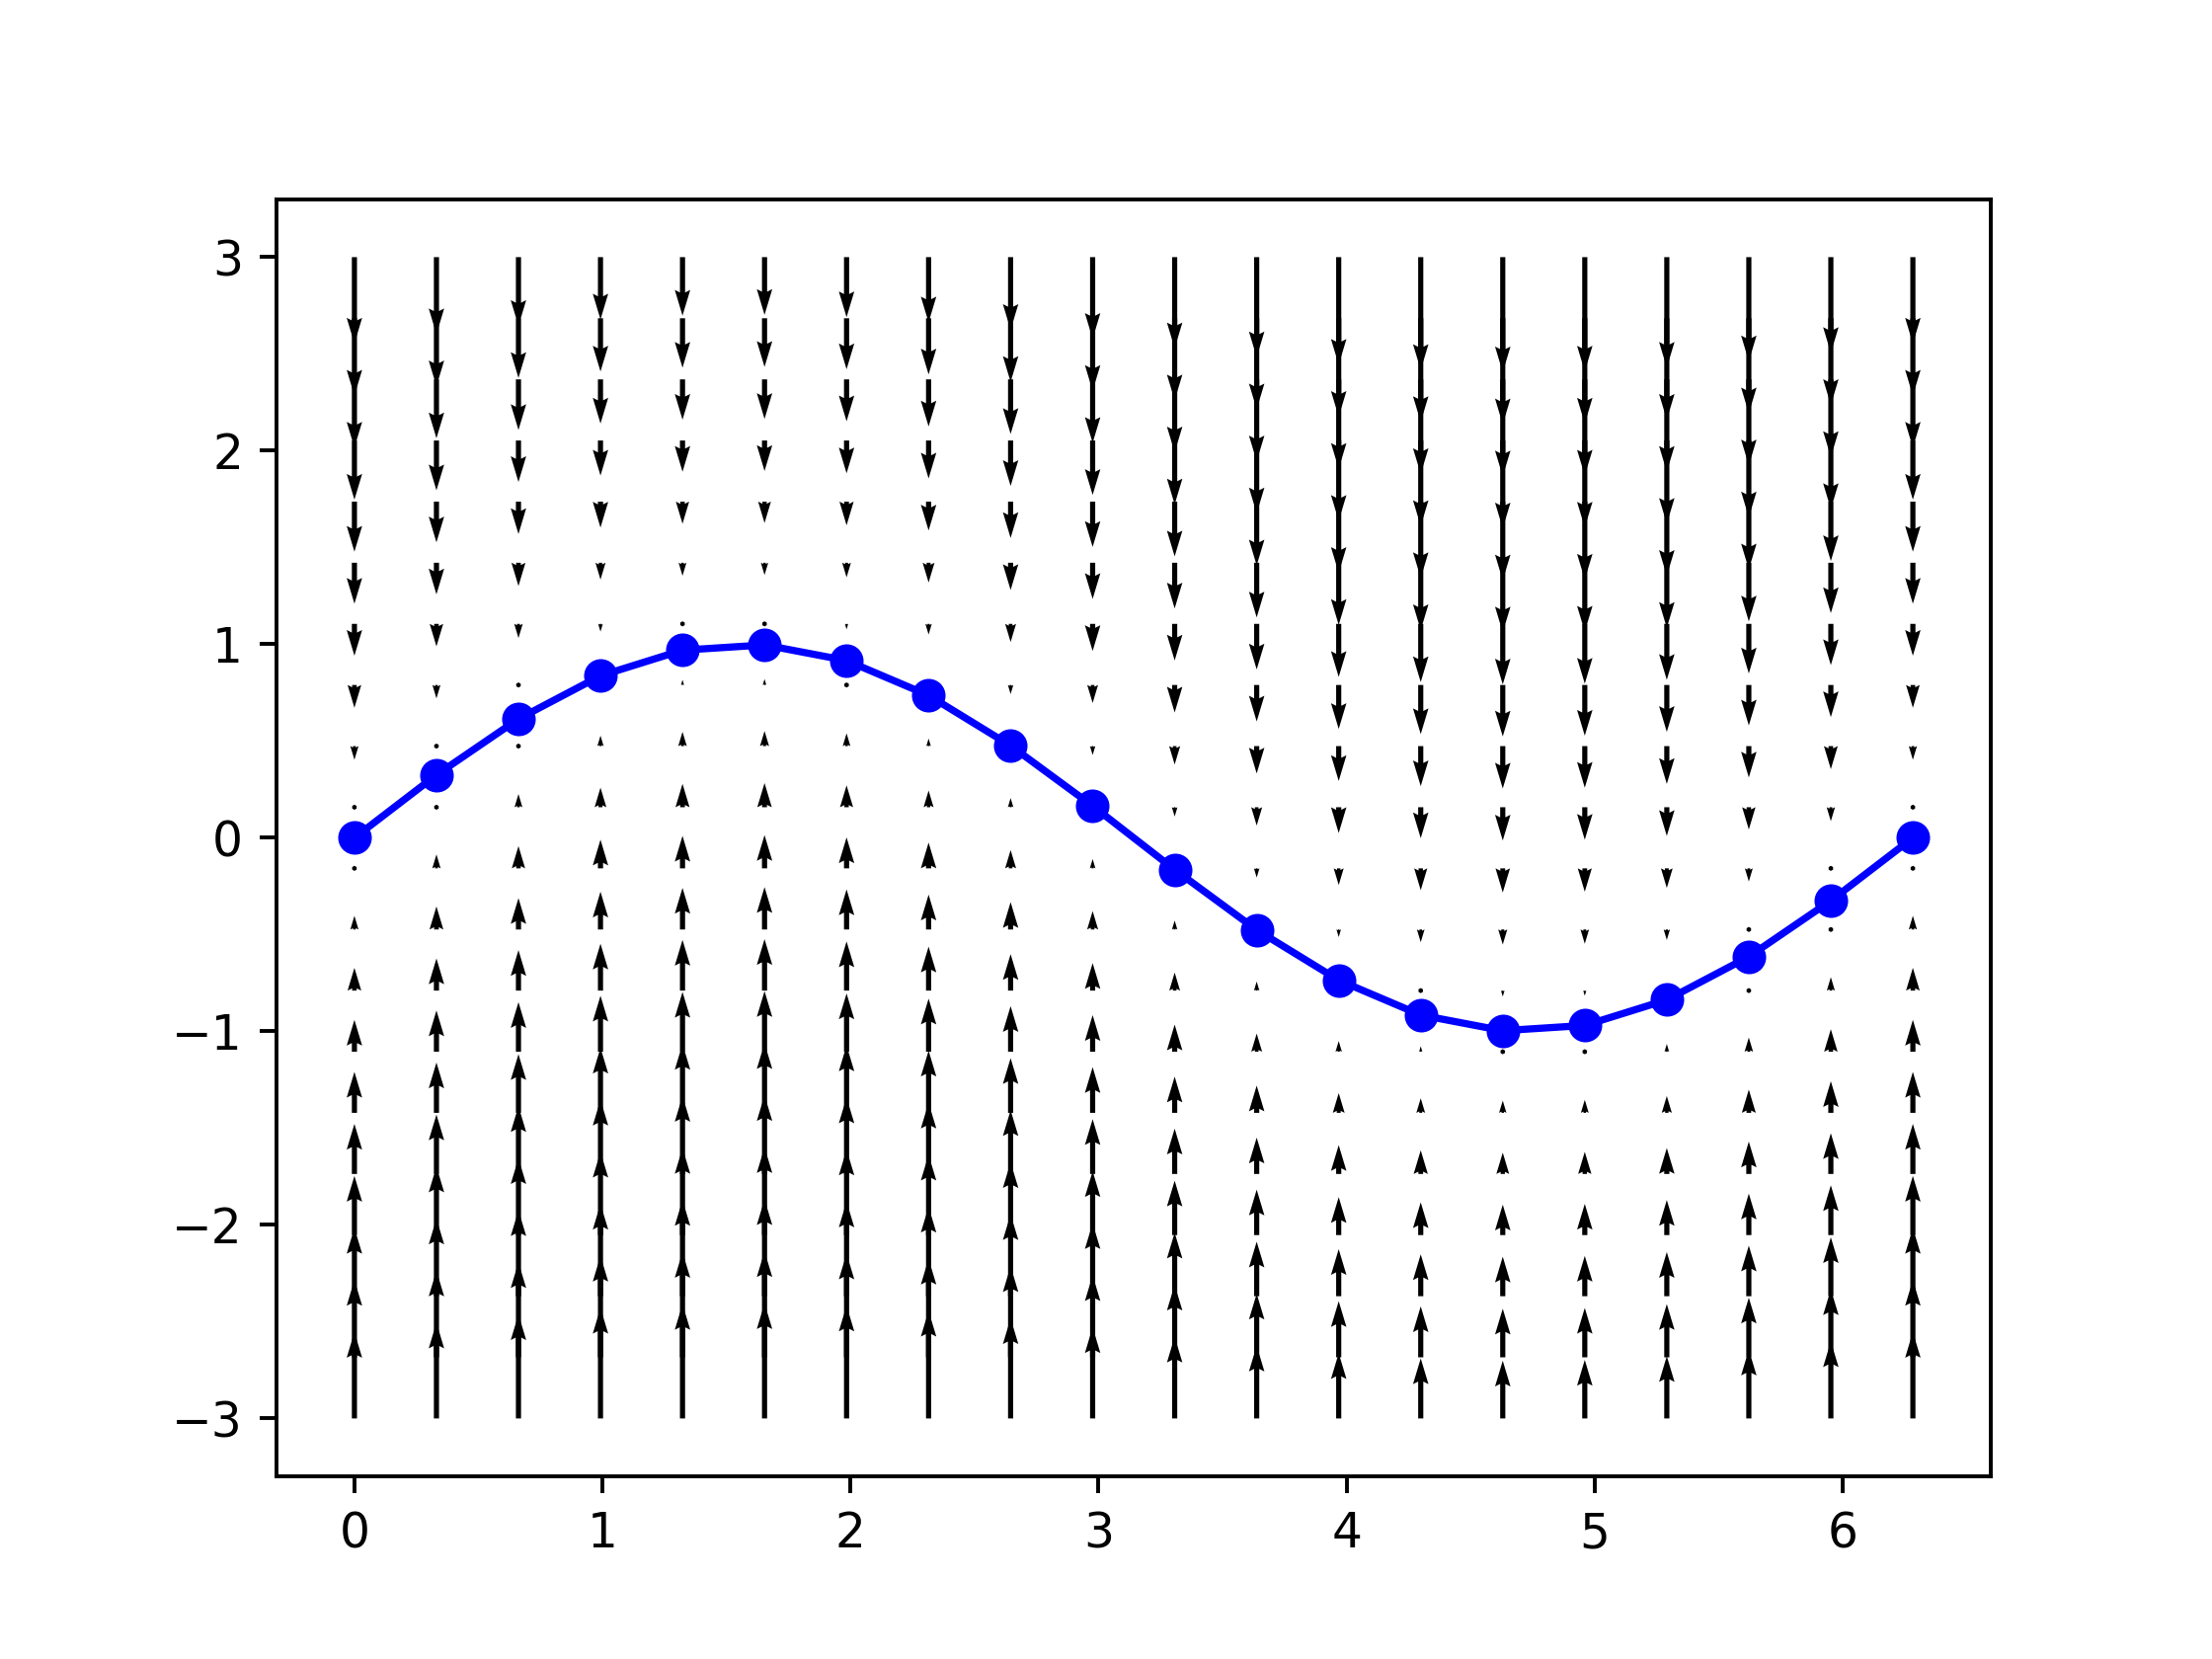

In [6]:
# Setup figure
fig, ax = plt.subplots()
# Create tspan and yspan for the vector field plot. Use 20 equally spaced points in both directions.
# tspan should go from 0 to 2*pi, yspan should go from -3 to 3
tspan = np.linspace(0, 2*np.pi, 20)
yspan = np.linspace(-3, 3, 20)
# Create the meshgrid
T, Y = np.meshgrid(tspan, yspan)
# Plot using quiver
ax.quiver(T, Y, np.ones(T.shape), 5e5*(-Y + np.sin(T)))

First let's see what happens when we solve this with the Backward-Euler method because we know it works well.

/Users/jeremyupsal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


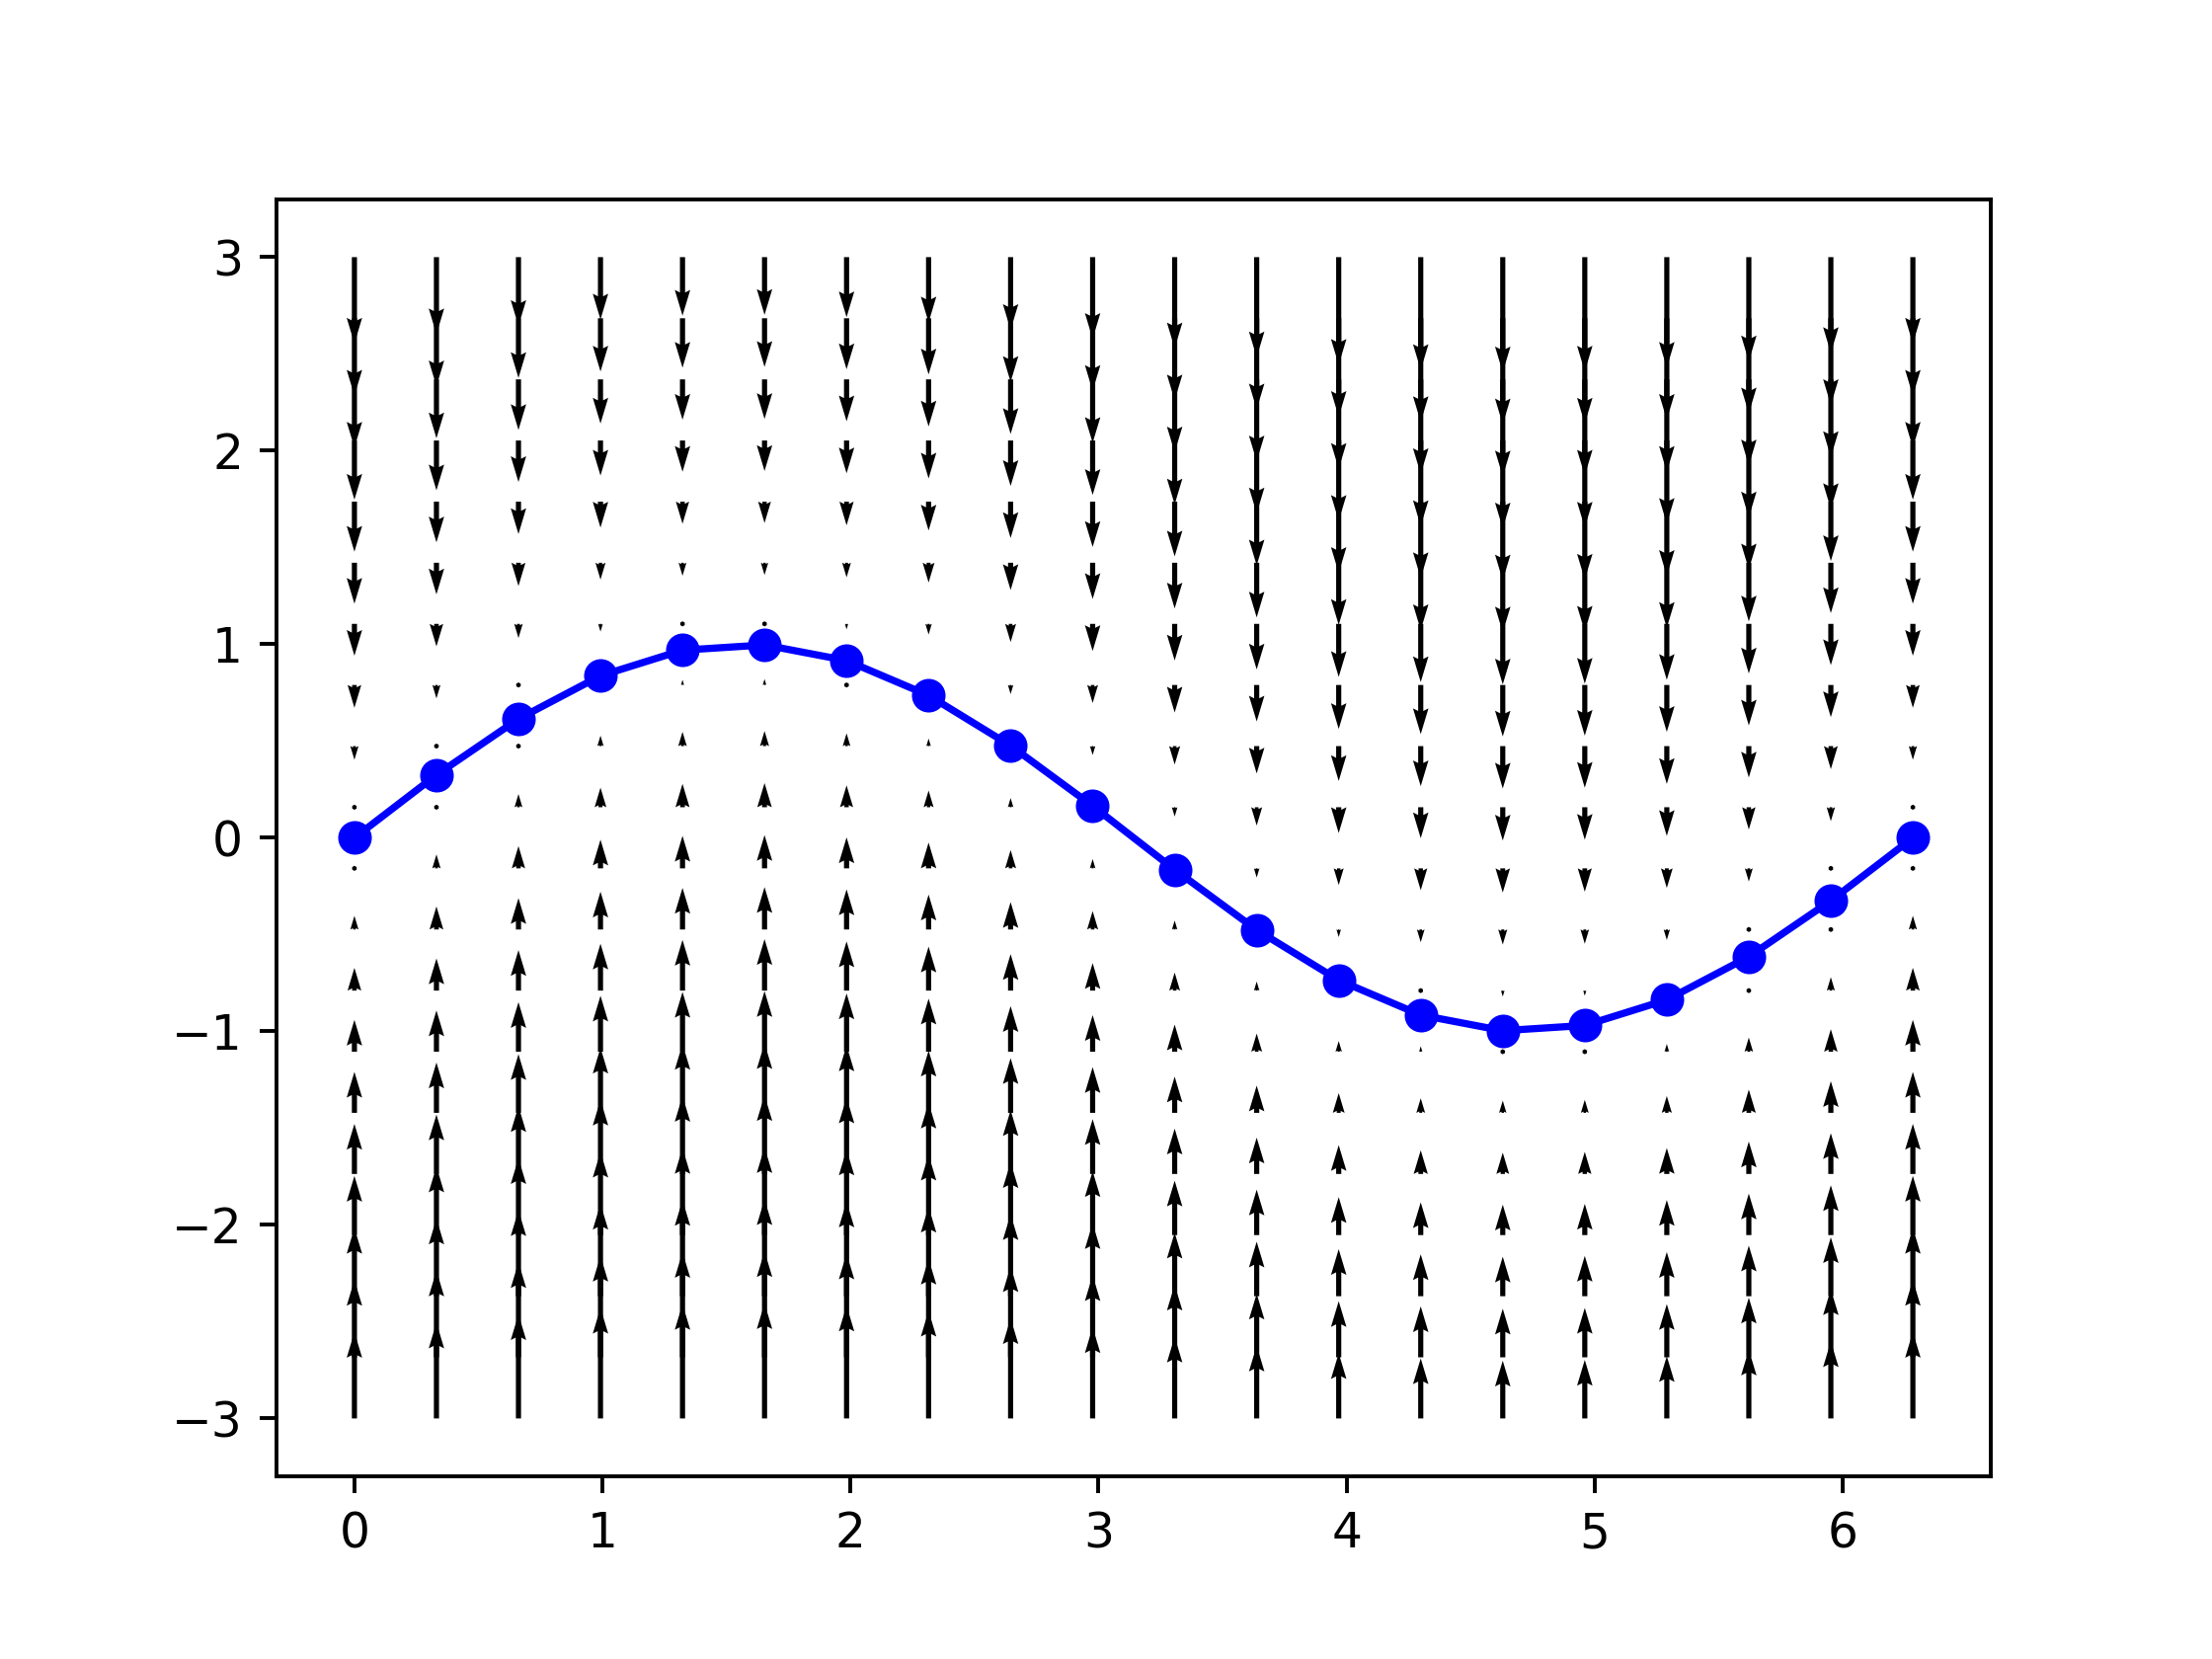

In [7]:
# Solve with Backward Euler
t, BE_ans = backward_euler(dydt, tspan, y0)
# Then plot the solution in blue. Dots with lines in between
ax.plot(t, BE_ans, 'bo-')
# Show the figure
fig

This should look strange to you. All of the slopes on the slope field look vertical. But, the solution is not vertical. It is a lot like a sine wave! But, we know that the solution always follows the slope field... so what’s up? To see what’s going on better, let’s change the differential equation a little bit. Let’s look at
$$y' = 2(−y + \sin(t)), ~ y(0) = 0.$$
We have changed the large constant out front. Doing so changes the figure.

<IPython.core.display.Javascript object>


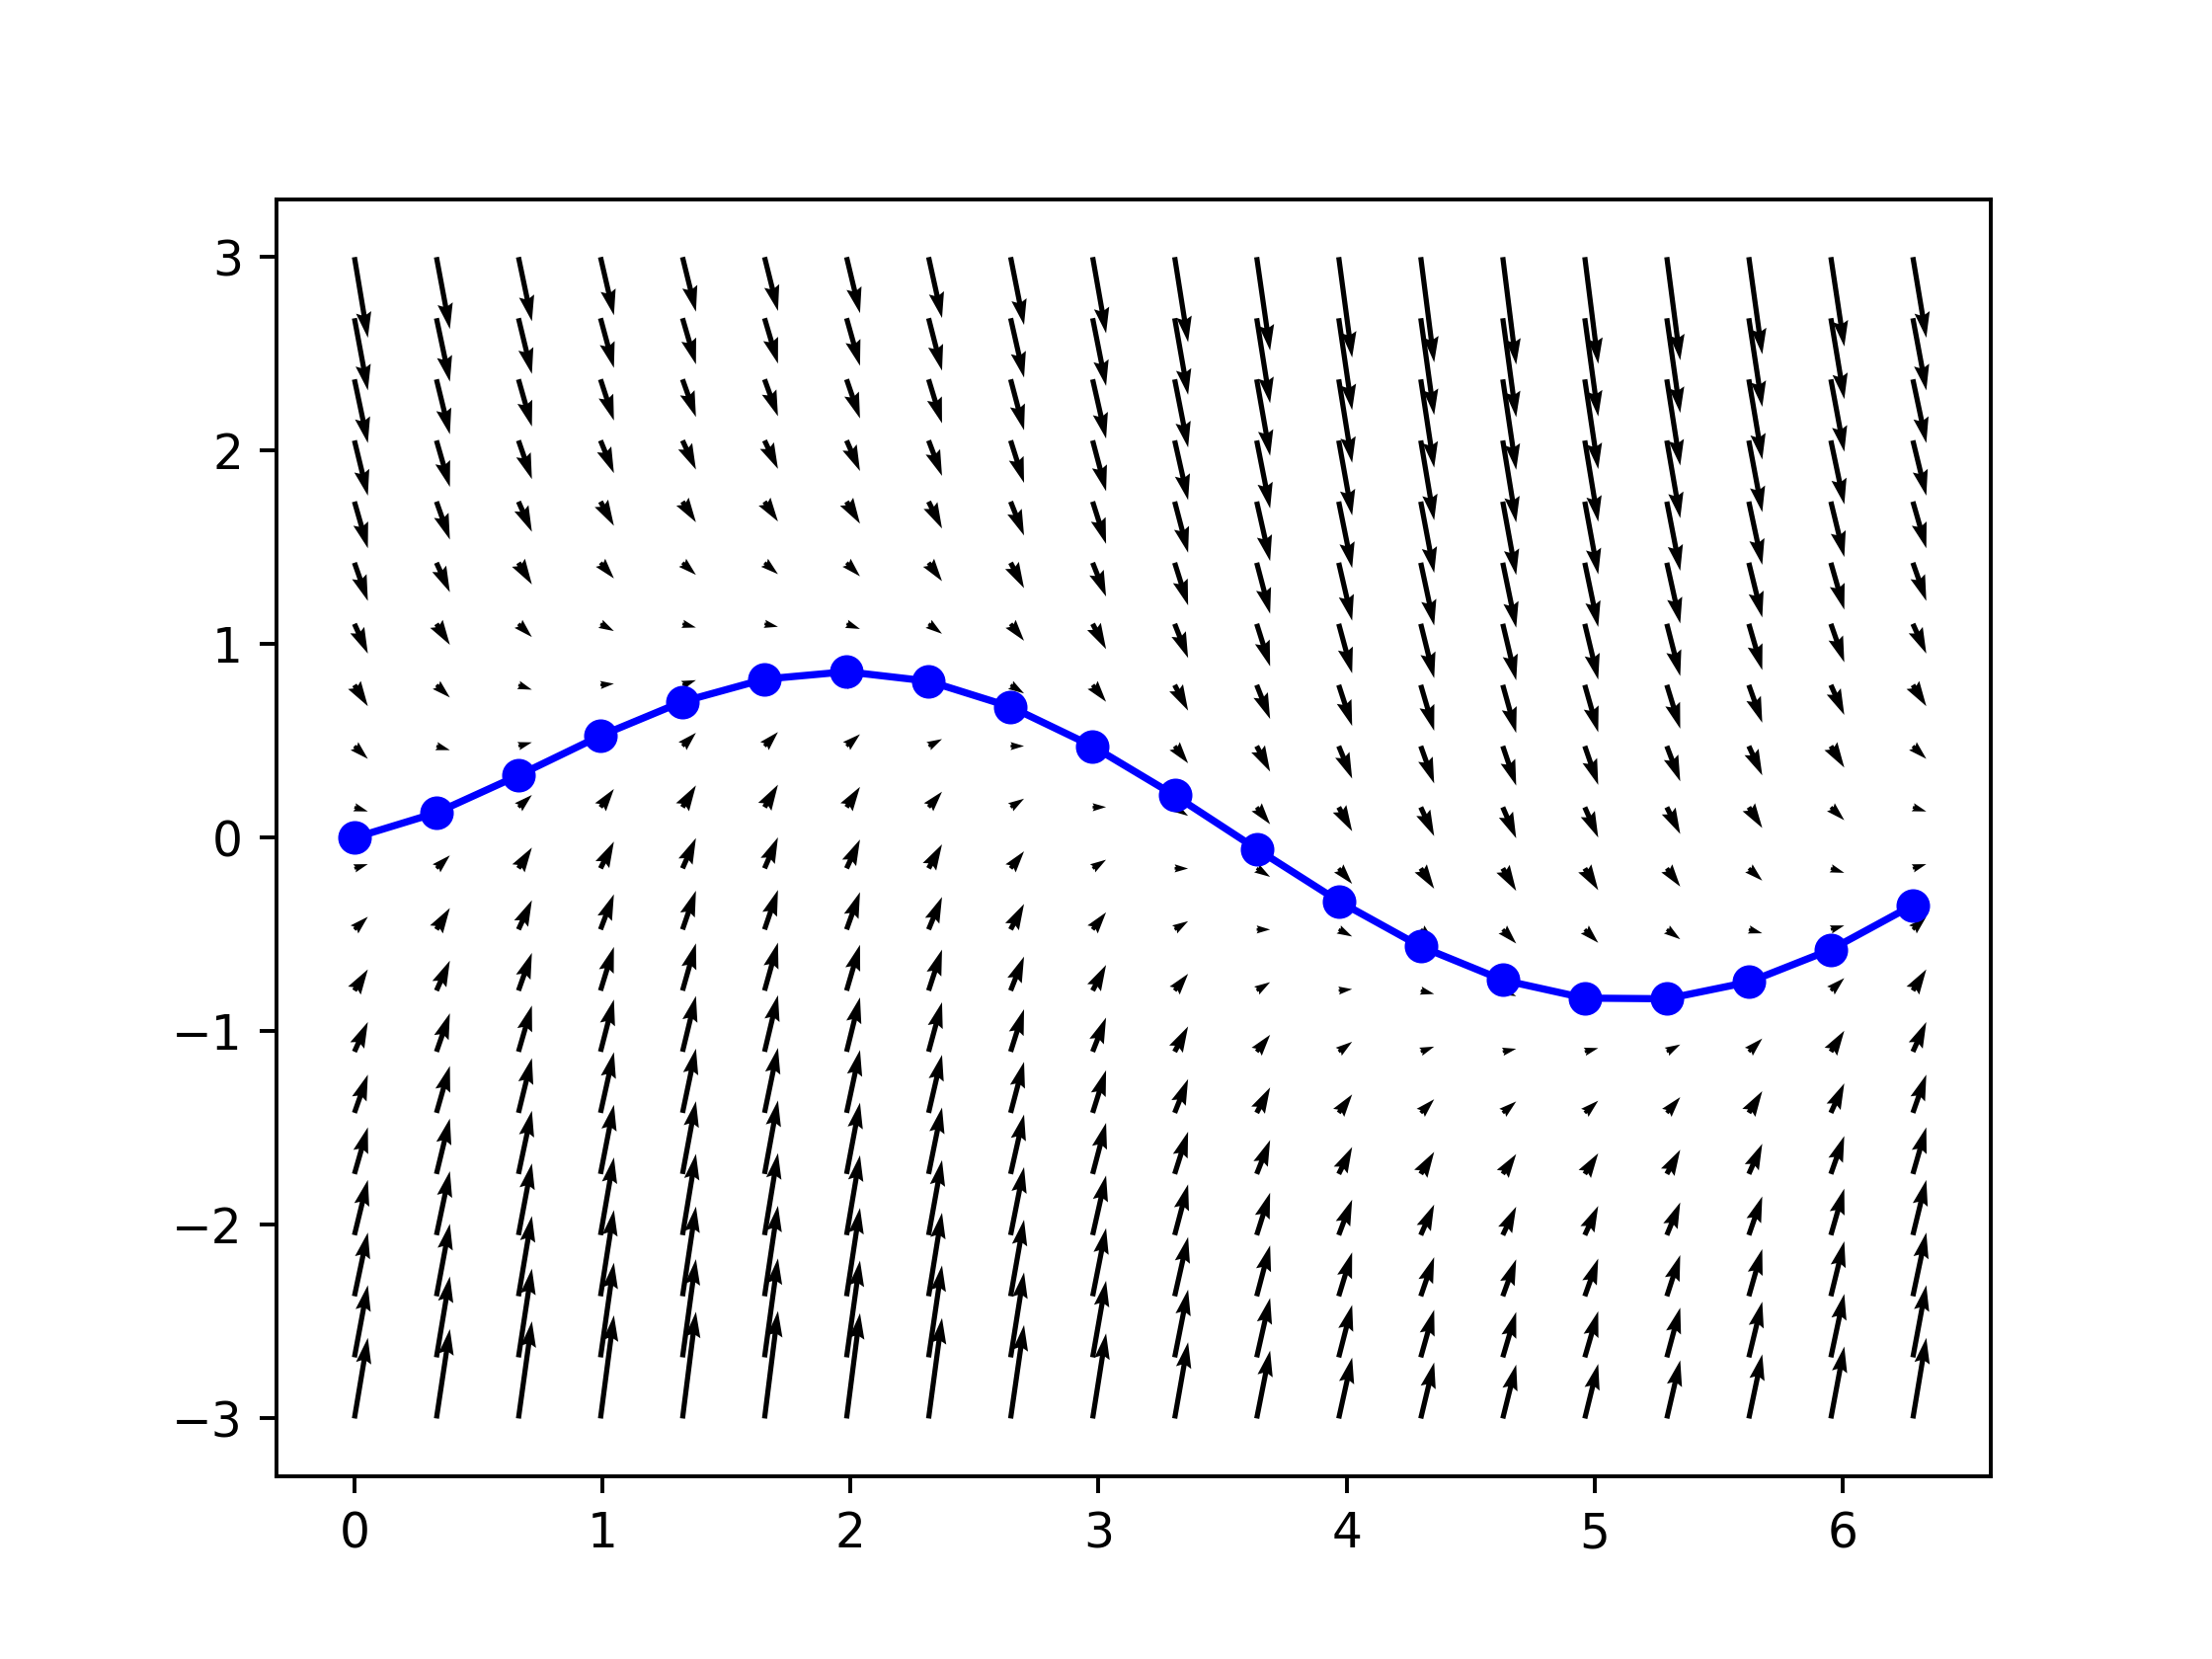

In [8]:
# Setup new figure
fig2, ax2 = plt.subplots()
# Create tspan and yspan for the vector field plot. Use 20 equally spaced points in both directions.
# tspan should go from 0 to 2*pi, yspan should go from -3 to 3
tspan = np.linspace(0, 2*np.pi, 20)
yspan = np.linspace(-3, 3, 20)
# Create the meshgrid
T, Y = np.meshgrid(tspan, yspan)
# Define the new ODE, dydt
dydt = lambda t, y: 2*(-y+np.sin(t))
# Plot using quiver
ax2.quiver(T, Y, np.ones(T.shape), dydt(T, Y))

# Calculate the solution using Backward Euler
t, BE_ans = backward_euler(dydt, tspan, y0)
# Then plot the solution in blue. Dots with lines in between
ax2.plot(t, BE_ans, 'bo-')

Notice that far away from the exact solution, the arrows of the slope field are closer to vertical but they curve in as we get close to the solution curve. If we increase the constant to 10, i.e.
$$ y'(t) = 10 (-y + \sin(t)), $$
we get the following figure.

<IPython.core.display.Javascript object>


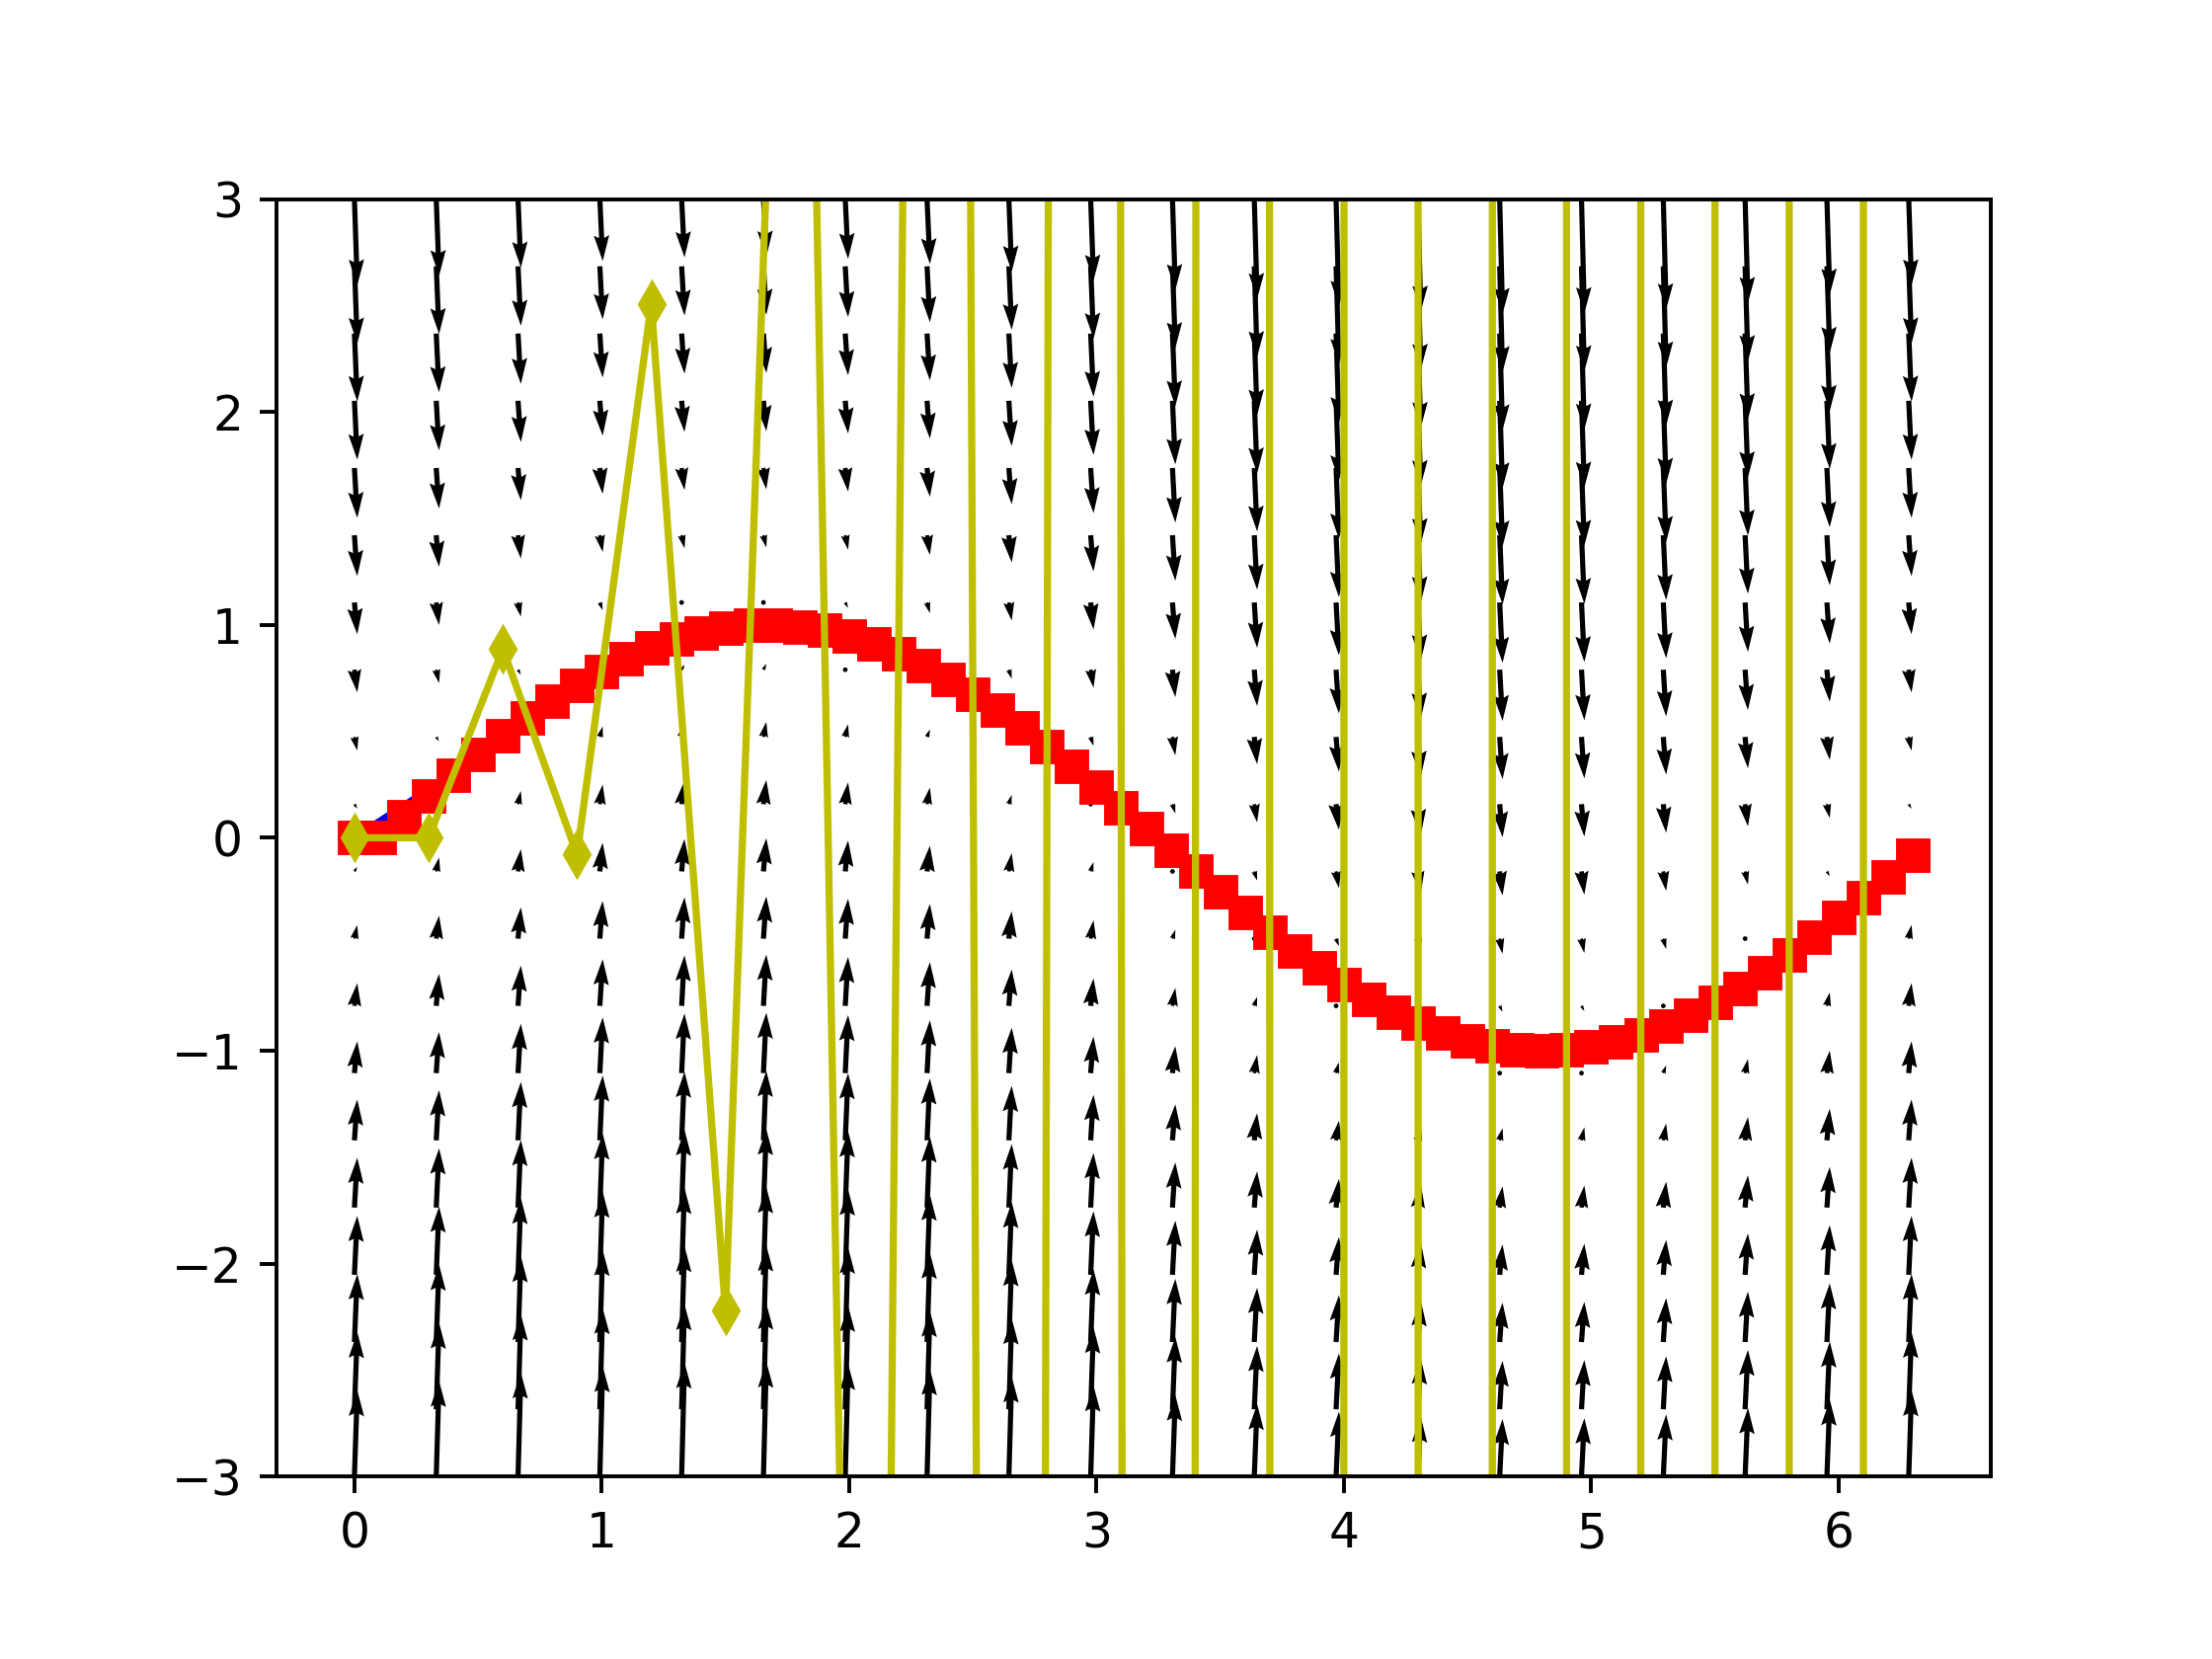

In [9]:
# Do all of the same steps as above, except with the constant = 10
# Setup new figure
fig3, ax3 = plt.subplots()
# Create tspan and yspan for the vector field plot. Use 20 equally spaced points in both directions.
# tspan should go from 0 to 2*pi, yspan should go from -3 to 3
tspan = np.linspace(0, 2*np.pi, 20)
yspan = np.linspace(-3, 3, 20)
# Create the meshgrid
T, Y = np.meshgrid(tspan, yspan)
# Define the new ODE, dydt
dydt = lambda t, y: 10*(-y+np.sin(t))
# Plot using quiver
ax3.quiver(T, Y, np.ones(T.shape), dydt(T, Y))

# Calculate the solution using Backward Euler
t, BE_ans = backward_euler(dydt, tspan, y0)
# Then plot the solution in blue. 
ax3.plot(t, BE_ans, 'b-')

Away from the solution, the slopes on the slope field are even more close to being vertical. The region around the exact solution where the arrows curve in toward the direction of the solution is thinner. So there is a region (near the solution) where the slope field changes very rapidly. **This is what makes a problem stiff.** If you go back to the case with the constant 5e5, the region around the exact solution where the slopes curve in is so small that we can’t even see it. That’s what makes this such a stiff problem.

Let's continue to work with this ODE, $y'(t) = 10 (-y + \sin(t)),$ to see what happens with Forward Euler. We saw that for $\Delta t$ small enough the solution converged (we got some small error). So let's choose a small $\Delta t$ and see what happens with the solution.

We will choose $\Delta t = 0.1$ and solve below. 

<IPython.core.display.Javascript object>


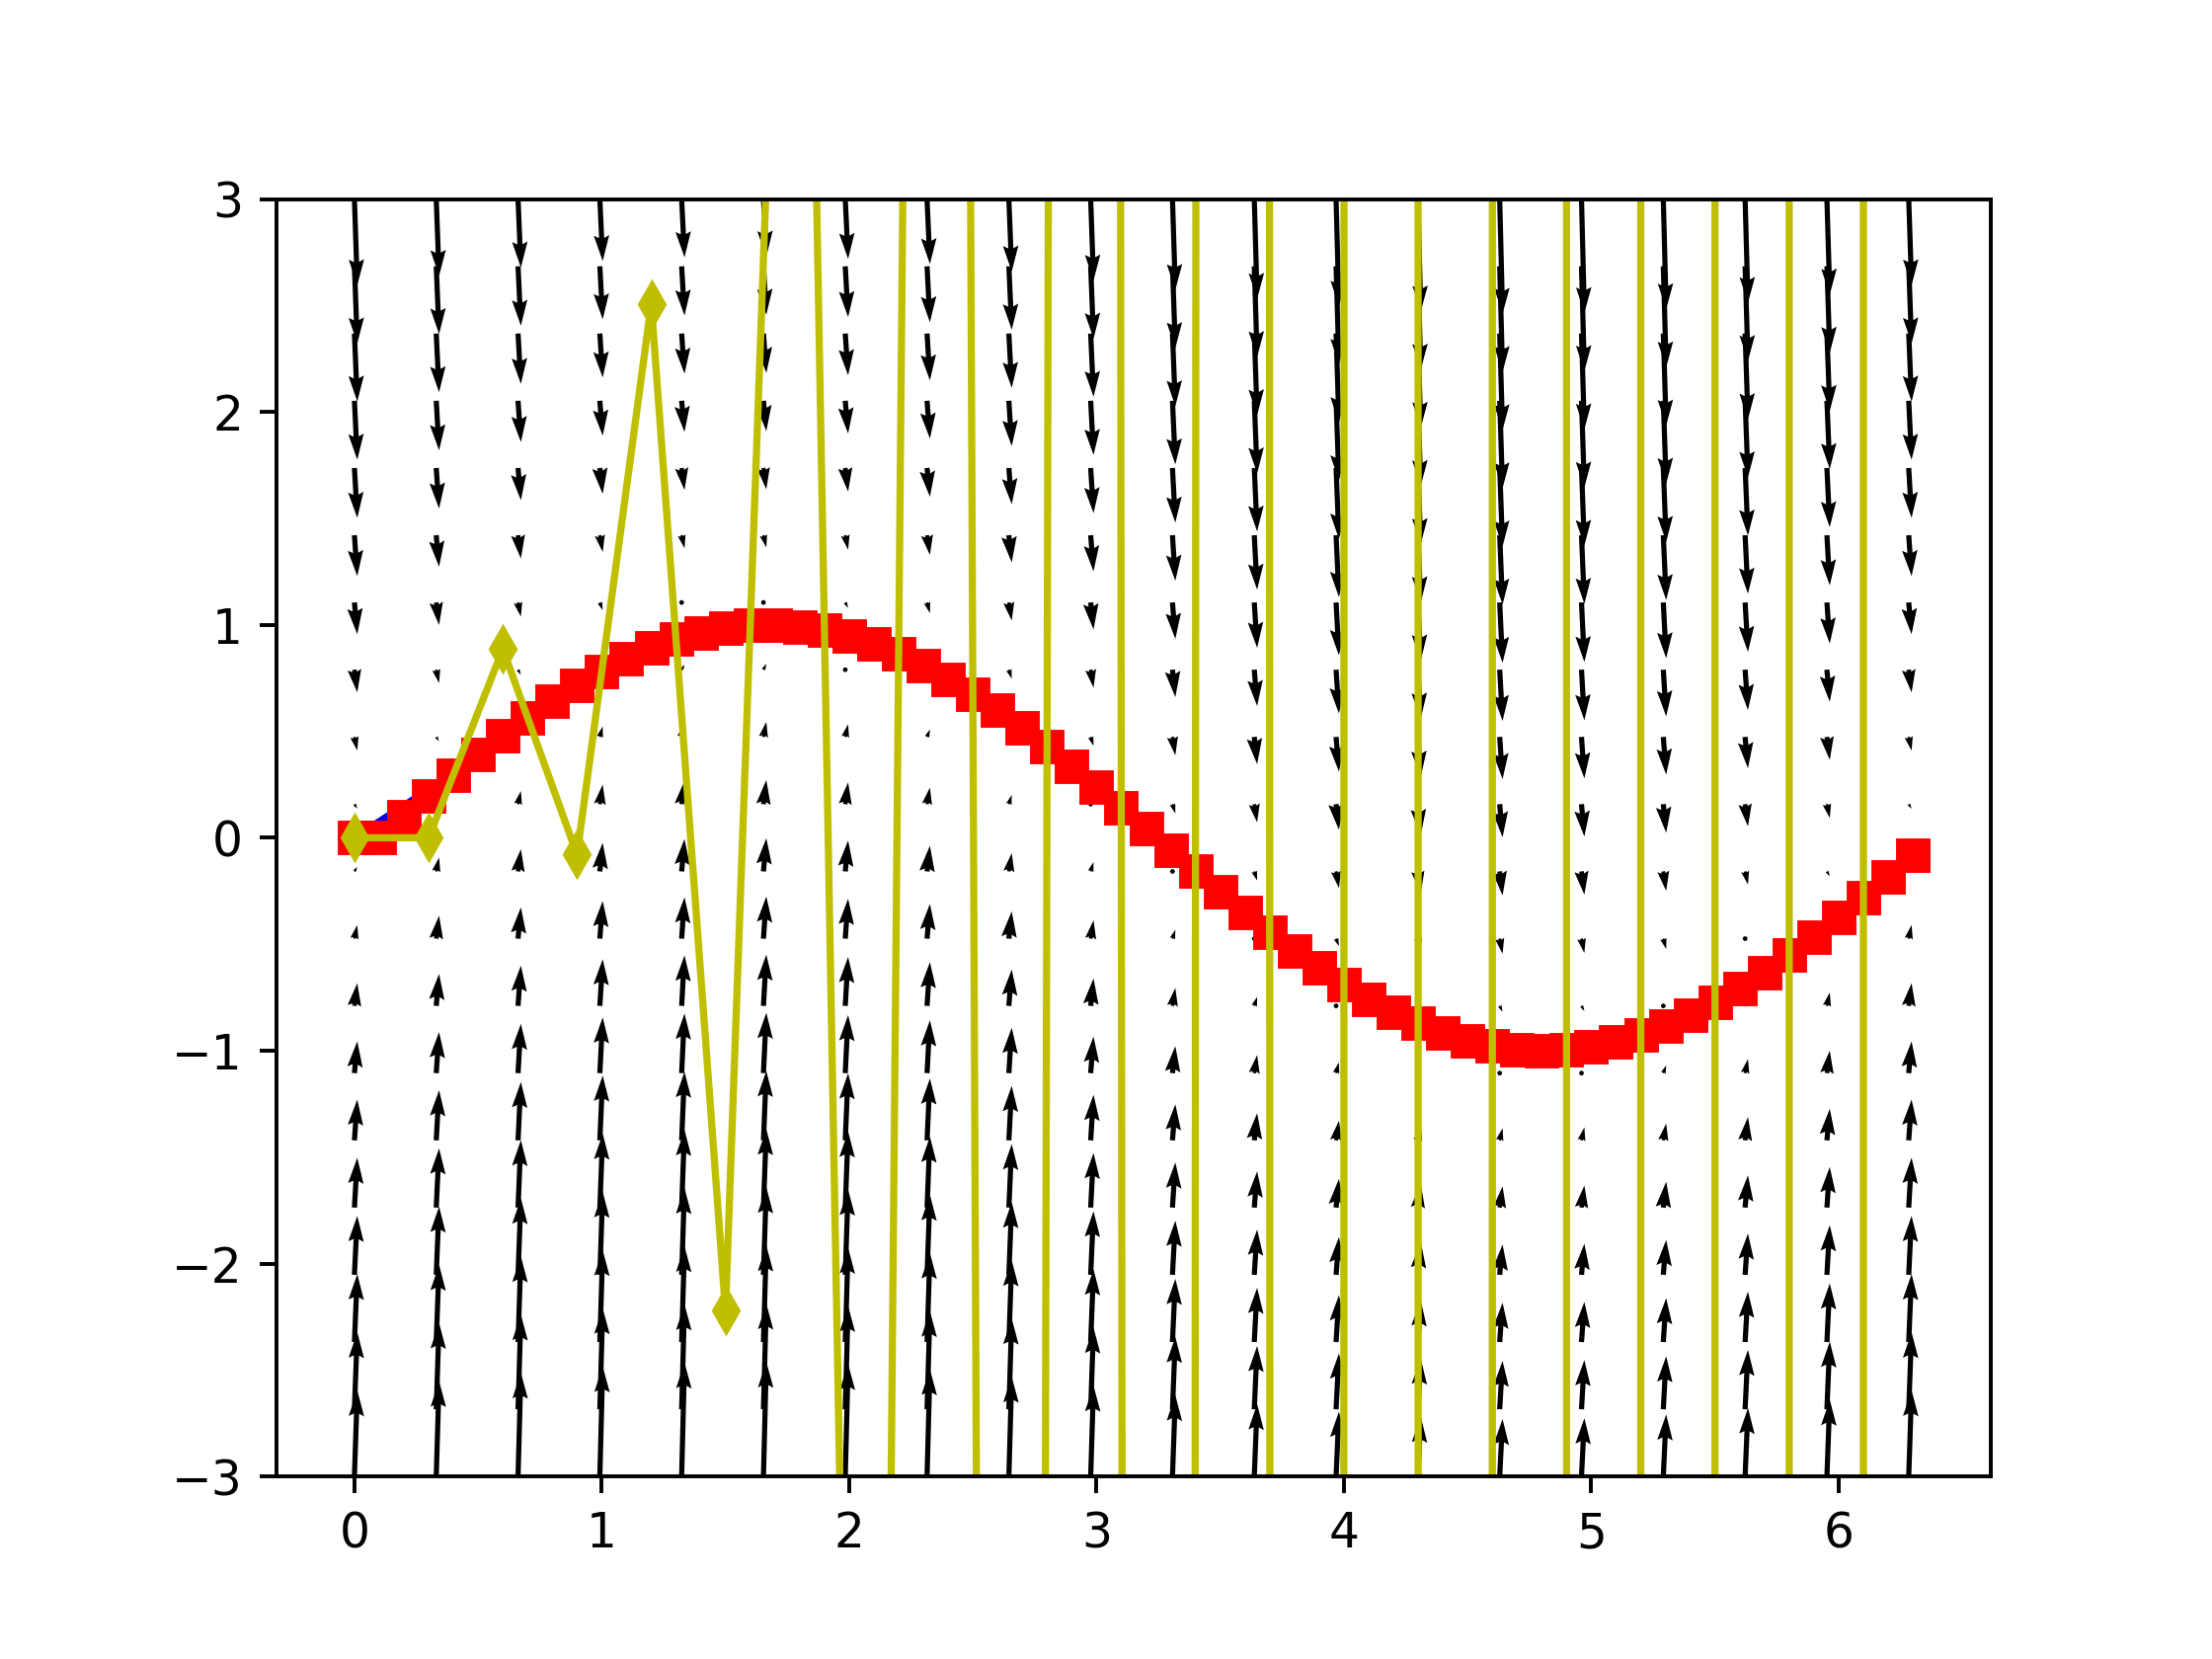

In [10]:
# Set dt
dt = 0.1
# Create the new tspan, from 0 to 2 pi with this dt
tspan = np.arange(0, 2*np.pi+dt, dt)
# Solve with Forward Euler
t, FE_ans = forward_euler(dydt, tspan, y0)
# Plot the solution using red squares
ax3.plot(t, FE_ans, 'rs-')

# Show the figure
fig3

We can see that the Forward-Euler solution matches up. What if we choose $\Delta t = 0.3$?

Let's solve with $\Delta t = 0.3$ and plot with yellow diamonds.

<IPython.core.display.Javascript object>


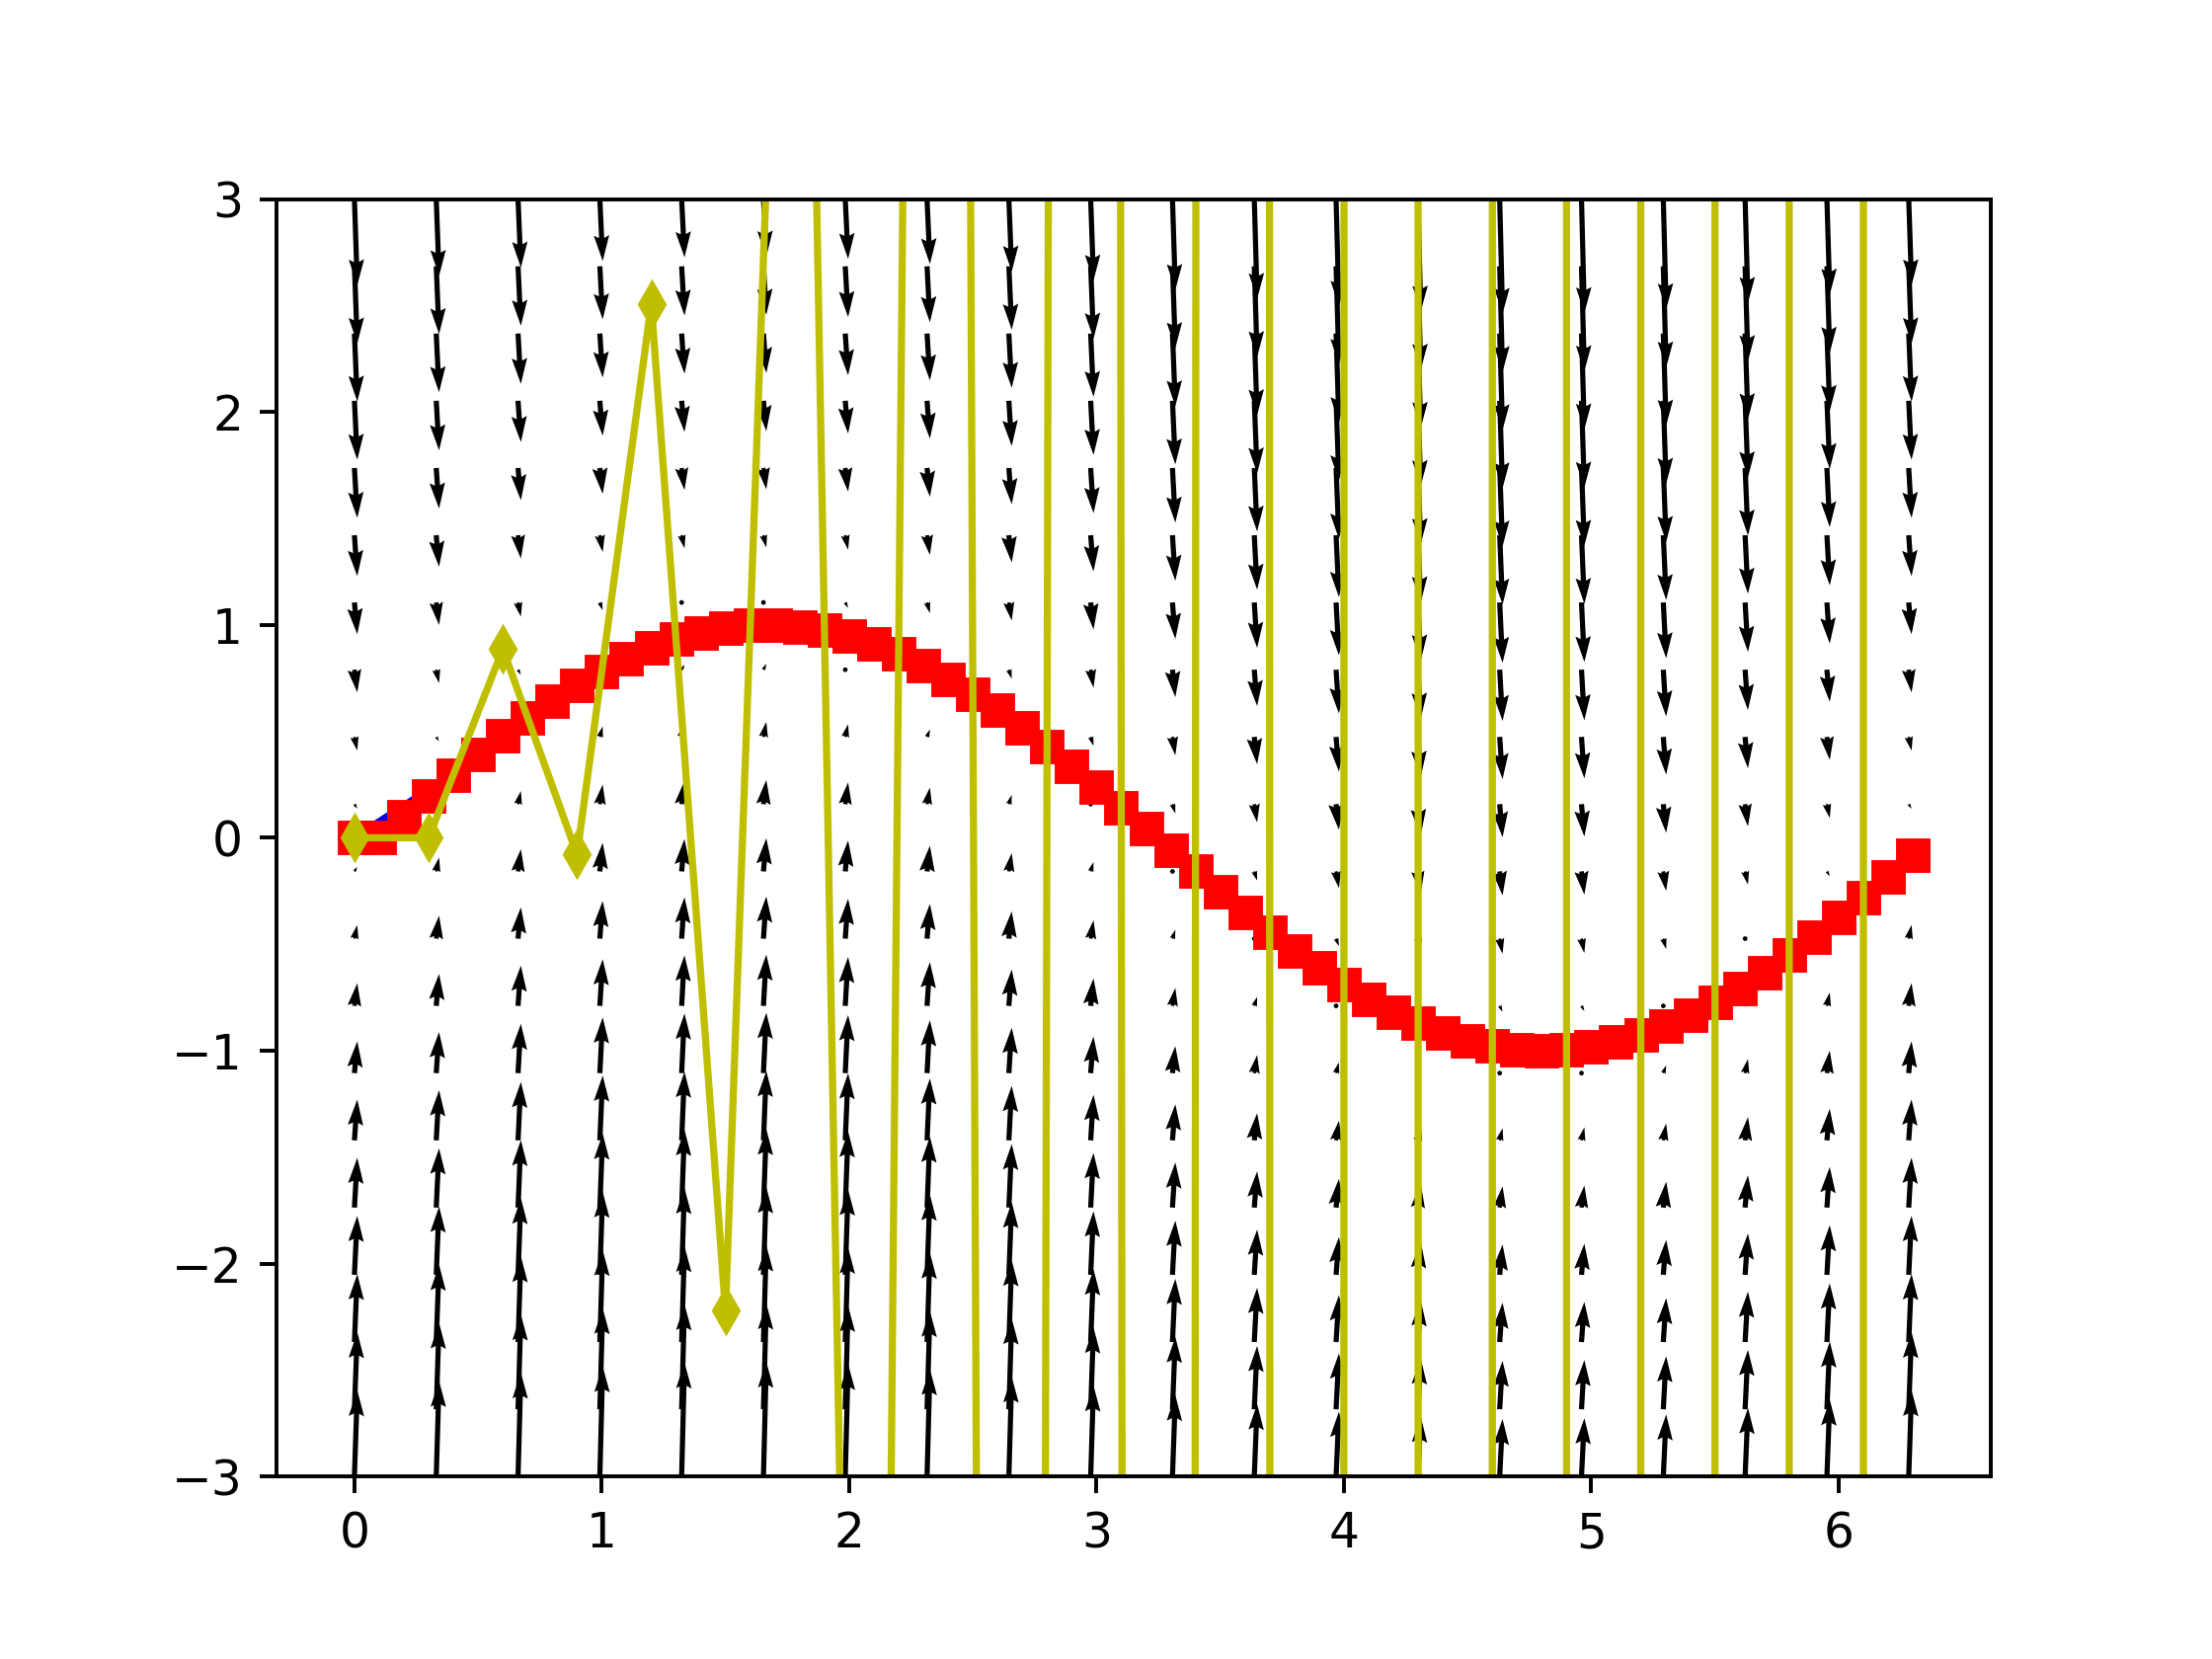

In [11]:
# Set dt
dt = 0.3
# Create the new tspan, from 0 to 2 pi with this dt
tspan = np.arange(0, 2*np.pi+dt, dt)
# Solve with Forward Euler
t, FE_ans = forward_euler(dydt, tspan, y0)
# Plot the solution using yellow diamonds
ax3.plot(t, FE_ans, 'yd-')

ax3.set_ylim([-3, 3]) # We are going to fix the ylimit.

# Show the figure
fig3

We can see that the solution is blowing up! There's some error in the first step, then some more error, then more and more etc. **This is numerical instability.**

Forward Euler becomes unstable because there is some error after the first step. Because you are not right on the curve after the first step, the slope field is relatively steep, causing an overshoot. Then the successive overshoots take you to regions where the slope field is even steeper. It is easy to see why this would be an even bigger problem using the constant 5e5 because almost all of the slopes on the slope field are nearly vertical. Even a small error off of the exact solution takes you to a region with a very steep slope in the opposite direction.

Backward Euler avoids this problem because it traces backward along the slope field. It can never end up in a region with nearly vertical slopes because if you trace any of them backward, you don’t end up near the exact solution. But *every explicit method will have this problem.* 

When using an explicit method, **very small step sizes are needed to solve stiff problems.** The method *will* work with a very small step size, but sometimes it can become prohibitively small, meaning the method will just take too long to converge. That is why we saw `solve_ivp` taking so long to solve; because `solve_ivp` will decrease the step size automatically to make the error small, it has to choose a very very small $\Delta t$, meaning that it is taking *more steps in the for loop*, which takes more time!

So, how do you identify stiff problems? When would you know which method to use?
- Usually you would start with using `solve_ivp` because it's highly accurate. If it's taking a long time, your ODE is probably stiff. You may want to use `method = BDF`. 
- You can also recognize stiff ODEs from the vector field itself. **If there is a small region where the vector field changes rapidly, then the problem is likely stiff.** (That's what we see here, the vector field goes from pointing straight up to horizontal in a narrow region).

Finally, just to reiterate:
- When you have a stiff problem, **use an implicit method.**
- Otherwise, use an **explicit method** because they are usually faster!

There's more **optional** material on stability at the end of this notebook. We will not talk about it in class, but if you are curious you can look over this. We will now move on from stability to begin talking about *linear algebra.*

# Linear algebra: vectors, matrices, and systems of equations.

Throughout this class we have seen several examples of vectors and matrices, though we have not used that terminology. Instead, we have been using the more general word *array.* 

For example, when we were finding the minimum of a 2D function using gradient descent, we had a guess/iteration, e.g., `p = np.array([6,4])`. We created this in python and can check the shape of it using the following code.

In [12]:
# Create p0
p0 = np.array([6,4])
# Print the shape of p0, using p0.shape
print(p0.shape)

(2,)


Notice that the *shape* of this is (2,). That means it has 2 entries. Remember that we can take the *norm* of this array using the formula $\|p_0\| = \sqrt{6^2 + 4^2},$ which comes from Pythagorean's theorem. We can also rewrite this $\|p_0\|^2 = 6^2 + 4^2$. 

Now instead of thinking about $p_0$ as an array, we are going to call it a *vector.* A vector is the same as a 1-Dimensional array, except vectors come in the two forms *column vector* and *row vector.* For example, we could say
$$ p_0 = \begin{pmatrix} 6 \\ 4\end{pmatrix}, \qquad \text{ or } \qquad p_0 = \begin{pmatrix} 6 & 4 \end{pmatrix}.$$
The first way of writing it is as a column vector, the second is as a row vector. We use this language because the first example is a single column and the second example is a single row.

Right now we haven't added anything new, we are just using different language *to store information* (vectors, like arrays, hold information: data, variables, etc.) A new important characteristic for vectors is how we multiply them. For example, what is $p_0\cdot p_0$? **For vectors (and matrices, as we will see later), we can only multiply if the dimensions match up.**

Let's define these vectors in python. To do so,  define
$$ p_0 = \begin{pmatrix} 6 \\ 4\end{pmatrix}, \qquad \text{ and } \qquad q_0 = \begin{pmatrix} 6 & 4 \end{pmatrix}.$$
$p_0$ and $q_0$ hold the same information but are different because one is a column and one is a row. Let's define them in python.

In [13]:
p_0 = np.array([[6], [4]])
q_0 = np.array([[6,4]])

# Print the shape of each
print(p_0.shape)
print(q_0.shape)

(2, 1)
(1, 2)


Notice the difference. Before when we defined arrays we just had one set of brackets. Now we need to say what goes in the rows and what goes in the columns. We read the size of $p_0$ as "2 rows, 1 column" and the size of $q_0$ as "1 row, 2 columns." 

**The important rule about matrix and vector multiplication, is that you can only multiply two things, $x$ and $y$ if their *inner* dimensions agree.** In other words, we **can** multiply $q_0 \cdot p_0$ because the dimensions are $(1,2) \times (2,1)$. The *inner dimension* of 2 agrees. To do this in python, we use `@`. 

In [14]:
answer =  q_0 @ p_0
print(answer)

[[52]]


I will demonstrate how to do this multiplication by hand in class. **You will not need to do extensive multiplication by hand, but it will be necessary to know how it works when we talk about *systems of equations.*** 

Notice that the answer is $52 = 36 + 16 = 6^2 + 4^2 = \|p_0\|^2$. Indeed, $\|p_0\|^2 = p_0^\intercal p_0$, where the $.^\intercal$ operator is called the *transpose* and works by changing rows to columns and columns to rows. Note that $q_0 = p_0^\intercal$ and $p_0 = q_0^\intercal.$

### Systems of linear equations
Okay, so why does this all matter? *Linear algebra allows us to work compactly and efficiently with large sets of data. This is primarily due to how multiplication is defined.* The first place this usually becomes helpful is in solving *systems of linear equations.* 

A linear system is a system of 1 or more equations that is only linear in the unknown variables. For example,
$$
\begin{align*}
x + 3y − z &= 0 ,\\
z &= 12,\\
12z − x &= 0,
\end{align*}
$$
is linear because there are no terms with multiple $x$, $y$, or $z$ values multiplying one another.
$$
\begin{align*}
x + 3y − z &= 0,\\
xz &= 12, \\
12z − x &= 0
\end{align*}
$$
is not a linear system of equations because of the $xz$ term. 

Linear systems can always be written compactly using linear algebra in the form $Ax = b$. For example,
$$
\begin{align*}
x + 3y − z &= 0,\\
z &= 12,\\
12z − x &= 0,
\end{align*}
$$
can be written as $Aw = b$ where
$$
A = \begin{pmatrix} 1 & 3 & -1 \\ 0 & 0 & 1 \\ -1 & 0 & 12 \end{pmatrix},  \qquad w = \begin{pmatrix} x \\ y \\ z \end{pmatrix}, \qquad b = \begin{pmatrix}0 \\ 12 \\ 0 \end{pmatrix}.
$$
(Note that I am using the variable $w$ to represent *the column vector of unknowns* instead of $x$, since one of our unknowns is called $x$). The variable $A$ is called a *matrix.* It has 3 rows and 3 columns. We can think about it as having 3 columns, each of which is a row with 3 elements, or as having 3 rows, each of which is a column with 3 elements.

In order to understand this equation, and particular the $Aw$ term, we need to know how matrix-vector multiplication works. The way we can do this, is by thinking about each equation on its own. The first equation, $x + 3y - z = 0$ can be written as the vector-vector product
$$ \begin{pmatrix} 1 & 3 & -1 \end{pmatrix} \begin{pmatrix}x \\ y \\ z\end{pmatrix} = 0.$$
You should take a minute to verify this yourself. The second equation, $z = 12$, is the same as
$$ 
\begin{pmatrix} 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} x \\ y \\ z \end{pmatrix} = 12.
$$
Finally, $12z - x = 0$ is the same as 
$$
\begin{pmatrix}
-1 & 0 & 12 
\end{pmatrix}
\begin{pmatrix} x \\ y \\ z \end{pmatrix} = 0.
$$
So now we can see how the matrix is defined: it takes the three *component* vectors for the *vector of unknowns* in terms of $x,~y,$ and $z$. We can also see how matrix-vector multiplication works. The result of the matrix-vector multiplication should be the right-hand side of the three equations above:
$$
b = \begin{pmatrix}
0 \\ 12 \\ 0
\end{pmatrix}.
$$
I will demonstrate by hand again how the matrix-vector multiplication works. You should practice it.

You can do matrix-vector multiplication in python using `@`. For example, we could compute $Ab$ (not related to the $Aw = b$ above) because $A$ has dimensions $3\times 3$ and $b$ has dimensions $3\times 1$. The output will be dimension $3 \times 1$:

In [15]:
# Define A
A = np.array([[1, 3, -1], [0, 0, 1], [-1, 0, 12]])
# Define b
b = np.array([[0],[12],[0]])

# Print the shape of A and b
print(A.shape)
print(b.shape)

# Calculate A*b
answer = A@b
print(answer.shape)
print(answer)

(3, 3)
(3, 1)
(3, 1)
[[36]
 [ 0]
 [ 0]]


But we don't really want to compute $Ab$. What we really want to know when we write $Aw = b$ is **what is w?** What are my $x,~y,$ and $z$? We solve equations like this in python using `np.linalg.solve(A, b)`.

In [16]:
# Solve for w
w = np.linalg.solve(A, b)
# Print w
print(w)

[[144.]
 [-44.]
 [ 12.]]


### Systems of linear ODEs
On the homework, we have a different type of *linear* equations, but still linear equations. That means that we can write them with matrix-vector multiplication. Coding Problem 3e, 
$$x''(t) - \mu x'(t) + x(t) = 0$$
can be written as (you should check this!)
$$
\begin{align*}
x'(t) &= y(t)\\
y'(t) &= \mu y(t) - x(t).
\end{align*}
$$
Let's see if we can extract the vectors and matrix! First off, I will define my *vector of unknowns*:
$$
w = \begin{pmatrix} x(t) \\ y(t) \end{pmatrix}.
$$
**This is the thing I want to solve for.** What else do I have? I have *the derivative of the $w$ vector,*
$$
w'(t) = \begin{pmatrix} x'(t) \\ y'(t) \end{pmatrix}.
$$
So I can write this system of equations as
$$
w'(t) = A w(t),
$$
but what is $A$? We will have to do some matrix-vector multiplication to check. We need
$$
w'(t) = \begin{pmatrix} x'(t) \\ y'(t) \end{pmatrix} = A w(t) = \begin{pmatrix} a & b \\ c & d \end{pmatrix} \begin{pmatrix} x(t) \\ y(t)\end{pmatrix}.
$$
I'll give you a minute to think about this.

What you should find is that 
$$
A = \begin{pmatrix} 
0 & 1 \\ -1 & \mu
\end{pmatrix}.
$$
Using this $A$ matrix will help us with the numerical methods: it helps simplify the notation (see the homework, for example!).

### Stability Material below is optional and we will not cover it in class. 

### Stability
Remember that stability has to do with how our solution behaves if we make the final time $T$ very large.  This turns out to be a very complicated concept, and it often depends on the details of our differential equation, so we will only look at one of the simplest versions of stability.  In particular, we will only talk about stability in terms of a very simple family of differential equations: 

$\dot{x} = \lambda x$ and $x(0) = x_0$, 

where $\lambda$ is a constant.  (It turns out that when we try to solve systems of equations we will need to worry about complex values of $\lambda$, but for the moment we will just pretend that $\lambda$ is real.)  This is called a *test problem*.  

**Note:** I am trying to avoid more technical definitions of stability and some of the more complicated concepts from differential equations.  Unfortunately, this means that I am also using somewhat non-standard definitions of words like "stable" and "unstable".  If you are interested in the standard definitions, a good place to start is by looking up "A-stability".  

We already saw in the previous lecture that the true solution to the test problem is 

$x(t) = x_0e^{\lambda t}$.  

We want to know what happens to this solution (and to our approximations, but let's start with the true solution) after a very long time.  In this case, there are only two possibilities.  If $\lambda > 0$, then $x$ goes off to $\pm\infty$ as time goes on.  We will call the true solution "unstable" in this case.  If $\lambda < 0$, then $x$ goes to zero as time goes on.  We will call the true solution "stable" in this case.  (Technically, there is a third possibility.  If $\lambda = 0$, then $x(t)$ stays constant forever.  However, this is a pretty degenerate case, so we won't worry about it here.)

Ideally, we want our numerical methods to capture this stable/unstable behavior.  That is, if we solve this initial value problem using something like the forward or backward Euler method, we want our approximation to go to infinity when $\lambda > 0$ and to go to zero when $\lambda < 0$.  Unfortunately, it turns out that this is not actually possible.  We will always have some tradeoff where our approximation goes to infinity even though the true solution does not, or vice versa.  

## Stability of Forward Euler
Let's look at what happens when we apply the forward Euler method to the test problem.  If we already know all of the $x$ values up to $x_k$, then we can find the next $x$ value using the equation 

$x_{k+1} = x_k + \Delta t f(t_k, x_k)$.  

In this case, $f(t, x) = \lambda x$, so we have 

$x_{k+1} = x_k + \Delta t \lambda x_k = (1 + \Delta t\lambda)x_k$.  

If we use this formula with $k = 0$, then we find 

$x_1 = (1 + \Delta t\lambda)x_0$.  

Likewise, if we use $k = 1$ then we find 

$x_2 = (1 + \Delta t\lambda)x_1 = (1 + \Delta t\lambda)^2x_0$.  

It is easy to check that if we repeat this process $k$ times we will get the general formula 

$x_k = (1 + \Delta t\lambda)^kx_0$.  

From this equation we can see that our approximations $x_k$ go to $\pm\infty$ if $|1 + \Delta t\lambda| > 1$.  If this is the case then we say that forward Euler is "unstable".  Likewise, if $|1 + \Delta t\lambda| < 1$ then our approximations $x_k$ go to zero and we say that forward Euler is "stable".  

It is very important to notice that this is not the same as the stability of the true solution.  The true solution is stable whenever $\lambda$ is negative, but it is easy to come up with combinations of $\Delta t$ and $\lambda$ where $\lambda$ is negative, but forward Euler is unstable.  For instance, if $\Delta t = 1$ and $\lambda = -10$, then $|1 + \Delta t\lambda| = 9 > 1$, so forward Euler is unstable even though the true solution is stable.  However, it is easy to check that if $\lambda$ is positive then $|1 + \Delta t\lambda| > 1$, so if the true solution is unstable then so is the forward Euler approximation.  

We therefore know that the forward Euler solution is unstable whenever the true solution is unstable, but sometimes forward Euler is not stable even though the true solution is stable.  In particular, if $-2 < \Delta t\lambda < 0$, then the forward Euler approximation will be stable, but if $\Delta t\lambda < -2$ then the forward Euler approximation will be unstable (even though the true solution is actually stable).  

Notice that, for any fixed value of $\lambda$, if we choose $\Delta t$ small enough then the stability of our approximation will always match the stability of the true solution, but if $\lambda$ is negative then we might need a very small $\Delta t$ to make sure that forward Euler is stable.  

## Stability of Backward Euler
Similarly, we can look at what happens when we apply the backward Euler method to the test problem.  If we already know all of the $x$ values up to $x_k$, then we can find the next $x$ value using the equation 

$x_{k+1} = x_k + \Delta t f(t_{k+1}, x_{k+1})$.  

In this case, $f(t, x) = \lambda x$, so we have 

$x_{k+1} = x_k + \Delta t\lambda x_{k+1}$.  

This is an implicit equation, but it is very easy to solve for $x_{k+1}$.  We get 

$x_{k+1} = \frac{1}{1 - \Delta t\lambda}x_k$.  

If we use this formula with $k = 0$, we find that 

$x_1 = \frac{1}{1 - \Delta t\lambda}x_0$.  

Likewise, if we use $k = 1$ then we find 

$x_2 = \frac{1}{1 - \Delta t\lambda}x_1 = \left(\frac{1}{1 - \Delta t\lambda}\right)^2x_0$.  

It is easy to check that if we repeat this process $k$ times we will get the general formula 

$x_k = \left(\frac{1}{1 - \Delta t\lambda}\right)^{k}x_0$.  

From this equation we can see that our approximations $x_k$ go to $\pm\infty$ if $|1/(1 - \Delta t\lambda)| > 1$.  If this is the case then we say that backward Euler is "unstable".  Likewise, if $|1/(1 - \Delta t\lambda)| < 1$ then our approximations $x_k$ go to zero and we say that backward Euler is "stable".  

Just like with forward Euler, it is very important to notice that this is not the same as the stability of the true solution (or as the rule for forward Euler).  In particular, if $\lambda$ is positive then the true solution is always unstable, but it is easy to come up with combinations of $\Delta t$ and $\lambda$ where $\lambda$ is positive but backward Euler is stable.  For example, if $\Delta t = 1$ and $\lambda = 10$, then $|1/(1 - \Delta t\lambda)| = 1/9 < 1$, so backward Euler is stable even though the true solution is unstable.  

We therefore know that the backward Euler solution is stable whenever the true solution is stable, but sometimes backward Euler is still stable even though the true solution is unstable.  In particular, the backward Euler approximation is only unstable when $0 < \Delta t\lambda < 2$.  If $\Delta t\lambda > 2$ then backward Euler will be stable (even though the true solution is actually unstable).  

For any fixed value of $\lambda$, if we choose $\Delta t$ small enough then the stability of our approximation will always match the stability of the true solution, but if $\lambda$ is positive then we might need a very small $\Delta t$ to make sure that the behavior of backward Euler matches that of the true solution.  

## Overview
We only analyzed the stability of a very limited set of differential equations (the test problems) and we only looked at two methods (forward and backward Euler), but it turns out that this analysis applies to a wide variety of problems and methods.  More complicated differential equations don't usually just go to zero as time goes on, but we are still interested in correctly capturing whatever long term behavior they have.  We will say that the solution to a differential equation is "stable" if it does *not* go to infinity as time goes on.  (This is not a very good definition, but we would have to spend several classes on differential equations theory in order to make a substantially better one.)  It turns out that explicit approximation methods are prone to going to infinity even when the true solution is stable, while implicit methods are good at capturing stable behavior.  This means that explicit methods often need a fairly small time step $\Delta t$ in order to correctly capture long-term stable behavior.  Implicit methods, on the other hand, can correctly capture long-term stable behavior even with a fairly large time step.  

In real world applications, solutions rarely go to infinity.  For example, if we are modeling the population of a species, there are physical limits (like space or resource requirements) that keep this population from becoming infinitely large.  Because of this, we typically expect the true solution of our initial value problems to be stable.  This means that implicit methods like backward Euler can usually correctly capture long-term behavior with a larger time step than explicit methods like forward Euler.  We therefore say that implicit methods like backward Euler have "better stability properties" or are "more stable" than explicit methods.  